In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error
from matplotlib import pyplot as plt
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import numpy as np
from scipy.stats import kurtosis

import numpy as np
import pandas as pd
# from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import random
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold

# Set the seed value for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

In [26]:
# Using adult data
# Some preprocessing steps
features_df = pd.read_csv('data/adult_data_features.csv')

# Replacing "?" with np.NaN
features_df = features_df.replace("?", np.nan)

# Dropping all rows with one or more null attributes
features_df = features_df.dropna()

# Dropping 'education' column since 'education-num' is the same column in numerical format
# Dropping 'fnlgwt' since don't know what it means
# features_df[['education', 'education-num']]
features_df = features_df.drop(['education', 'fnlwgt'], axis=1)

# Converting all categorical variables using one hot encoding
features_df = pd.get_dummies(features_df, columns=['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'native-country', 'sex'], dtype='int')

# Changing dtype to float
features_df = features_df.astype('float')

# Get corresponding labels
labels = pd.read_csv('data/adult_data_targets.csv')
labels = labels.loc[features_df.index, :]

# Sanitizing the labels by replacing "<=50K." with "<=50K" and ">50K." with ">50K"
labels.replace({"<=50K.": "<=50K", ">50K.": ">50K"}, inplace=True)

# Change the labels to 0 and 1
labels = labels.map(lambda x : 1 if x == ">50K" else 0)

labels.value_counts()

# Standardize the data for all features except the categorical variables
scaler = StandardScaler()
features_df.loc[:,['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']] = scaler.fit_transform(features_df.loc[:,['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']])

X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.2, random_state=seed_value, stratify=labels)


In [16]:
# Test wall clock time. Can see number of seconds on VS code.
model = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=30, batch_size=128, verbose=0)

In [20]:
# Test accuracy
model.evaluate(X_test, y_test)

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8390 - loss: 0.3367


[0.33199718594551086, 0.8444444537162781]

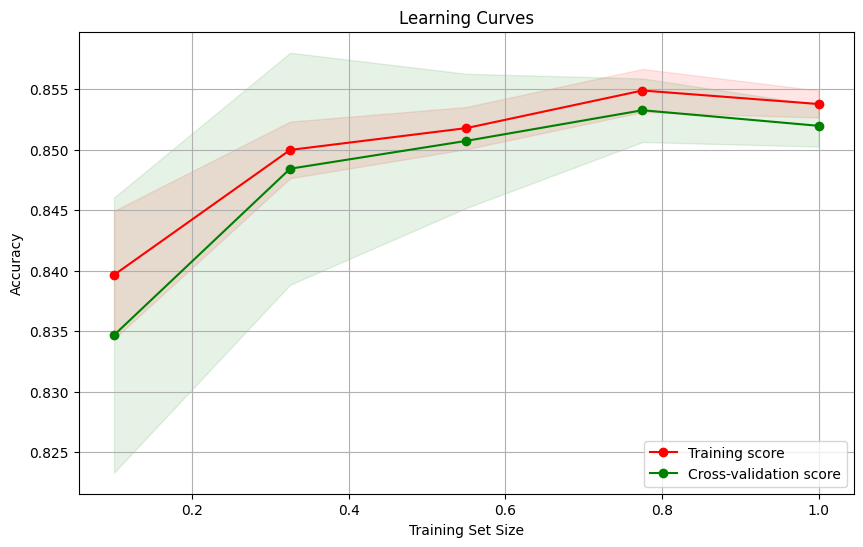

In [27]:
def create_model(seed=None):
    model = keras.models.Sequential([
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    return model


# Define different training sizes
train_sizes = np.linspace(0.1, 1.0, 5)

kf = KFold(n_splits=5, shuffle=True, random_state=seed_value)

train_mean_scores = []
val_mean_scores = []
train_std_scores = []
val_std_scores = []

for train_size in train_sizes:
    train_scores = []
    val_scores = []

    # Select a subset of the training data
    subset_size = int(X_train.shape[0] * train_size)
    X_subset = X_train[:subset_size]
    y_subset = y_train[:subset_size]

    for train_index, val_index in kf.split(X_subset):
        X_train_fold, X_val_fold = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
        y_train_fold, y_val_fold = y_train.iloc[train_index, :], y_train.iloc[val_index, :]
        
        model = create_model(seed=seed_value)
        
        history = model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=128, validation_data=(X_val_fold, y_val_fold), verbose=0)
        
        train_scores.append(history.history['accuracy'][-1])
        val_scores.append(history.history['val_accuracy'][-1])

    train_mean_scores.append(np.mean(train_scores))
    train_std_scores.append(np.std(train_scores))
    val_mean_scores.append(np.mean(val_scores))
    val_std_scores.append(np.std(val_scores))

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean_scores, 'o-', color='r', label='Training score')
plt.plot(train_sizes, val_mean_scores, 'o-', color='g', label='Cross-validation score')

plt.fill_between(train_sizes, 
                 np.array(train_mean_scores) - np.array(train_std_scores), 
                 np.array(train_mean_scores) + np.array(train_std_scores), 
                 alpha=0.1, color='r')
plt.fill_between(train_sizes, 
                 np.array(val_mean_scores) - np.array(val_std_scores), 
                 np.array(val_mean_scores) + np.array(val_std_scores), 
                 alpha=0.1, color='g')

plt.title('Learning Curves')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

In [24]:
# Apply PCA
pca = PCA(n_components=10)  # Choose the number of components
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

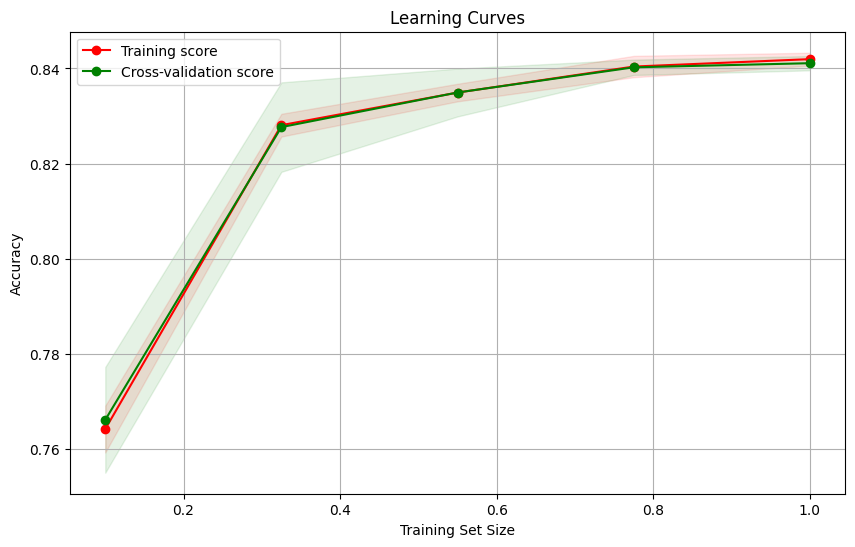

In [10]:
def create_model(seed=None):
    model = keras.models.Sequential([
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(64, activation='sigmoid'),
        keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    return model


# Define different training sizes
train_sizes = np.linspace(0.1, 1.0, 5)

kf = KFold(n_splits=5, shuffle=True, random_state=seed_value)

train_mean_scores = []
val_mean_scores = []
train_std_scores = []
val_std_scores = []

for train_size in train_sizes:
    train_scores = []
    val_scores = []

    # Select a subset of the training data
    subset_size = int(X_train.shape[0] * train_size)
    X_subset = X_train[:subset_size]
    y_subset = y_train[:subset_size]

    for train_index, val_index in kf.split(X_subset):
        X_train_fold, X_val_fold = X_train[train_index, :], X_train[val_index, :]
        y_train_fold, y_val_fold = y_train.iloc[train_index, :], y_train.iloc[val_index, :]
        
        model = create_model(seed=seed_value)
        
        history = model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=128, validation_data=(X_val_fold, y_val_fold), verbose=0)
        
        train_scores.append(history.history['accuracy'][-1])
        val_scores.append(history.history['val_accuracy'][-1])

    train_mean_scores.append(np.mean(train_scores))
    train_std_scores.append(np.std(train_scores))
    val_mean_scores.append(np.mean(val_scores))
    val_std_scores.append(np.std(val_scores))

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean_scores, 'o-', color='r', label='Training score')
plt.plot(train_sizes, val_mean_scores, 'o-', color='g', label='Cross-validation score')

plt.fill_between(train_sizes, 
                 np.array(train_mean_scores) - np.array(train_std_scores), 
                 np.array(train_mean_scores) + np.array(train_std_scores), 
                 alpha=0.1, color='r')
plt.fill_between(train_sizes, 
                 np.array(val_mean_scores) - np.array(val_std_scores), 
                 np.array(val_mean_scores) + np.array(val_std_scores), 
                 alpha=0.1, color='g')

plt.title('Learning Curves')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

In [13]:
# Test accuracy
model.evaluate(X_test, y_test)

283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8344 - loss: 0.3488


[0.3434431552886963, 0.8390271067619324]

In [19]:
model = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=30, batch_size=128, verbose=0)